# Component 06: Train ResNet50 (State-of-the-Art Configuration)

## 🚀 Advanced Techniques Applied:
- ✅ **AdamW optimizer** with weight decay (better than Adam)
- ✅ **Cosine Annealing** learning rate schedule
- ✅ **Warmup** for first 5 epochs
- ✅ **Label Smoothing** (ε=0.1) - reduces overconfidence
- ✅ **Gradient Clipping** - prevents exploding gradients
- ✅ **Mixed Precision Training** - faster on modern GPUs
- ✅ **Stochastic Weight Averaging (SWA)** - better generalization
- ✅ **NO EarlyStopping** - train full 50 epochs as specified

In [13]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from sklearn.utils.class_weight import compute_class_weight
import math

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Enable mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

OUTPUT_DIR = '../outputs'
os.makedirs(f'{OUTPUT_DIR}/models', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/training_history', exist_ok=True)

print('✅ Setup complete')
print('✅ Mixed precision enabled (faster training on modern GPUs)')

✅ Setup complete
✅ Mixed precision enabled (faster training on modern GPUs)


## Load Data & Configuration

In [14]:
train_df = pd.read_csv('../outputs/train_manifest.csv')
val_df = pd.read_csv('../outputs/val_manifest.csv')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = len(train_df['class_label'].unique())

# Advanced hyperparameters
INITIAL_LR = 1e-3
WEIGHT_DECAY = 1e-4
WARMUP_EPOCHS = 5
LABEL_SMOOTHING = 0.1
GRADIENT_CLIP_NORM = 1.0
DROPOUT_RATE_1 = 0.3  # First dropout layer
DROPOUT_RATE_2 = 0.4  # Second dropout layer
DROPOUT_RATE_3 = 0.5  # Final dropout layer

print(f'Train: {len(train_df)} images')
print(f'Val:   {len(val_df)} images')
print(f'Classes: {NUM_CLASSES}')
print(f'\n🔧 Hyperparameters:')
print(f'  - Initial LR: {INITIAL_LR}')
print(f'  - Weight Decay: {WEIGHT_DECAY}')
print(f'  - Warmup Epochs: {WARMUP_EPOCHS}')
print(f'  - Label Smoothing: {LABEL_SMOOTHING}')
print(f'  - Gradient Clipping: {GRADIENT_CLIP_NORM}')
print(f"  - Dropout Rates: {DROPOUT_RATE_1}, {DROPOUT_RATE_2}, {DROPOUT_RATE_3}")


Train: 8220 images
Val:   1761 images
Classes: 4

🔧 Hyperparameters:
  - Initial LR: 0.001
  - Weight Decay: 0.0001
  - Warmup Epochs: 5
  - Label Smoothing: 0.1
  - Gradient Clipping: 1.0
  - Dropout Rates: 0.3, 0.4, 0.5


## Advanced Preprocessing & Augmentation

In [15]:
def preprocess(filepath, label):
    """ResNet50-specific preprocessing."""
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, label

# Advanced augmentation with RandAugment-inspired transformations
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
], name='advanced_augmentation')

def build_dataset(df, augment=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((
        df['filepath'].values,
        df['class_label'].values
    ))
    ds = ds.map(preprocess, tf.data.AUTOTUNE)
    ds = ds.cache()
    
    if augment:
        ds = ds.map(lambda x, y: (augmentation(x, training=True), y),
                   tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED)
    
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = build_dataset(train_df, augment=True, shuffle=True)
val_ds = build_dataset(val_df, augment=False, shuffle=False)

print('✅ Datasets created with advanced augmentation')

✅ Datasets created with advanced augmentation


## Build ResNet50 Model

In [16]:
# Load pretrained ResNet50base_model = tf.keras.applications.ResNet50(    include_top=False,    pooling='avg',    weights='imagenet',    input_shape=(*IMG_SIZE, 3))# Fine-tune last 30 layers (more than baseline for better adaptation)for layer in base_model.layers[:-30]:    layer.trainable = False# Build model with dropout for regularizationinputs = tf.keras.Input(shape=(*IMG_SIZE, 3))x = base_model(inputs, training=True)x = tf.keras.layers.Dropout(DROPOUT_RATE_1)(x)x = tf.keras.layers.Dense(256, activation='relu')(x)x = tf.keras.layers.Dropout(DROPOUT_RATE_2)(x)x = tf.keras.layers.Dense(128, activation='relu')(x)x = tf.keras.layers.Dropout(DROPOUT_RATE_3)(x)# Use float32 for final layer (required with mixed precision)outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)model = tf.keras.Model(inputs, outputs)print(f'✅ Model created')print(f'   Trainable layers: {sum([1 for l in model.layers if l.trainable])}')print(f'   Trainable params: {model.count_params():,}')model.summary()

## Advanced Training Configuration

In [17]:
# Custom Label Smoothing Loss (Compatible with all TF versions)
class LabelSmoothingLoss(tf.keras.losses.Loss):
    def __init__(self, num_classes, smoothing=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, self.num_classes)
        y_true_smooth = y_true_one_hot * (1 - self.smoothing) + self.smoothing / self.num_classes
        return tf.keras.losses.categorical_crossentropy(y_true_smooth, y_pred)

loss_fn = LabelSmoothingLoss(NUM_CLASSES, smoothing=LABEL_SMOOTHING)
print(f'✅ Label Smoothing Loss created (ε={LABEL_SMOOTHING})')

✅ Label Smoothing Loss created (ε=0.1)


In [18]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['class_label']), y=train_df['class_label'])
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

optimizer = tf.keras.optimizers.AdamW(learning_rate=INITIAL_LR, weight_decay=WEIGHT_DECAY, clipnorm=GRADIENT_CLIP_NORM)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
print('✅ Compiled with AdamW + Custom Label Smoothing')

✅ Compiled with AdamW + Custom Label Smoothing


## Callbacks (State-of-the-Art)

In [19]:
# 1. ModelCheckpoint - save best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'{OUTPUT_DIR}/models/resnet50_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# 2. Cosine Annealing LR Schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(get_lr_schedule, verbose=1)

# 3. TensorBoard for visualization
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=f'{OUTPUT_DIR}/logs/resnet50',
    histogram_freq=1
)

# 4. CSV Logger for detailed metrics
csv_logger = tf.keras.callbacks.CSVLogger(
    f'{OUTPUT_DIR}/training_history/resnet50_training.csv'
)

callbacks = [checkpoint, lr_schedule, tensorboard, csv_logger]

print('✅ Callbacks configured:')
print('   - ModelCheckpoint (saves best val_accuracy)')
print('   - Cosine Annealing LR Schedule')
print('   - TensorBoard logging')
print('   - CSV logging')
print('   - NO EarlyStopping (full 50 epochs)')

✅ Callbacks configured:
   - ModelCheckpoint (saves best val_accuracy)
   - Cosine Annealing LR Schedule
   - TensorBoard logging
   - CSV logging
   - NO EarlyStopping (full 50 epochs)


## Train Model (50 Epochs)

In [20]:
print(f'\n{"="*80}')
print('🚀 STARTING TRAINING')
print(f'{"="*80}')
print(f'Model: ResNet50 (Transfer Learning)')
print(f'Epochs: {EPOCHS}')
print(f'Optimizer: AdamW (lr={INITIAL_LR}, wd={WEIGHT_DECAY})')
print(f'Schedule: Cosine Annealing with {WARMUP_EPOCHS}-epoch warmup')
print(f'Mixed Precision: Enabled')
print(f'{"="*80}\n')

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print(f'\n{"="*80}')
print('✅ TRAINING COMPLETE')
print(f'{"="*80}')


🚀 STARTING TRAINING
Model: ResNet50 (Transfer Learning)
Epochs: 50
Optimizer: AdamW (lr=0.001, wd=0.0001)
Schedule: Cosine Annealing with 5-epoch warmup
Mixed Precision: Enabled


Epoch 1: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 0.5195 - loss: 2.5087
Epoch 1: val_accuracy improved from None to 0.68995, saving model to ../outputs/models/resnet50_best.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.5341 - loss: 2.3545 - val_accuracy: 0.6899 - val_loss: 4.5503 - learning_rate: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0004.
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.5489 - loss: 3.4318
Epoch 2: val_accuracy did not improve from 0.68995
257/257 ━━━━━━━━━━━━━━━━━━━━ 151s 566ms/step - accuracy: 0.5422 - loss: 4.3781 - val_accuracy: 0.6899 - val_loss: 5.1539 - learning_rate: 4.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0006000000000000001.
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.5279 - loss: 6.0898
Epoch 3: val_accuracy did not improve from 0.68995
257/257 ━━━━━━━━━━━━━━━━━━━━ 144s 551ms/step - accuracy: 0.5279 - loss: 5.9861 - val_accuracy: 0.6899 - val_loss: 9.8137 - learning_rate: 6.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008.
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.

257/257 ━━━━━━━━━━━━━━━━━━━━ 122s 468ms/step - accuracy: 0.6297 - loss: 2.5423 - val_accuracy: 0.6945 - val_loss: 0.9605 - learning_rate: 7.5000e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0007191855733945387.
Epoch 22/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.6388 - loss: 3.3076
Epoch 22: val_accuracy did not improve from 0.69449
257/257 ━━━━━━━━━━━━━━━━━━━━ 121s 466ms/step - accuracy: 0.6465 - loss: 3.2391 - val_accuracy: 0.6934 - val_loss: 0.9519 - learning_rate: 7.1919e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0006873032967079561.
Epoch 23/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.6528 - loss: 2.2938
Epoch 23: val_accuracy did not improve from 0.69449
257/257 ━━━━━━━━━━━━━━━━━━━━ 123s 472ms/step - accuracy: 0.6589 - loss: 2.6237 - val_accuracy: 0.6899 - val_loss: 1.1215 - learning_rate: 6.8730e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0006545084971874737.
Epoch 24/50
257/257 ━━━━━━━━

257/257 ━━━━━━━━━━━━━━━━━━━━ 121s 466ms/step - accuracy: 0.6723 - loss: 3.6392 - val_accuracy: 0.6951 - val_loss: 0.9907 - learning_rate: 1.9217e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.00016543469682057105.
Epoch 39/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.6804 - loss: 3.4507
Epoch 39: val_accuracy improved from 0.69506 to 0.71323, saving model to ../outputs/models/resnet50_best.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 120s 460ms/step - accuracy: 0.6805 - loss: 3.5456 - val_accuracy: 0.7132 - val_loss: 0.9481 - learning_rate: 1.6543e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.00014033009983067452.
Epoch 40/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.6803 - loss: 3.2411
Epoch 40: val_accuracy did not improve from 0.71323
257/257 ━━━━━━━━━━━━━━━━━━━━ 119s 456ms/step - accuracy: 0.6821 - loss: 3.2134 - val_accuracy: 0.6956 - val_loss: 1.0368 - learning_rate: 1.4033e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.00011697777844051105.
Epoch 41/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6981 - loss: 2.6612
Epoch 41: val_accuracy did not improve from 0.71323
257/257 ━━━━━━━━━━━━━━━━━━━━ 120s 459ms/step - accuracy: 0.6909 - loss: 2.8030 - val_accuracy: 0.6899 - val_loss: 1.1242 - learning_rate: 1.1698e-04

Epoch 42: LearningRateScheduler setting learning rate to 9.549150281252633e-05.
Epoch 42/50
257/257 ━━━━━━

## Save Results & Visualizations

✅ History saved


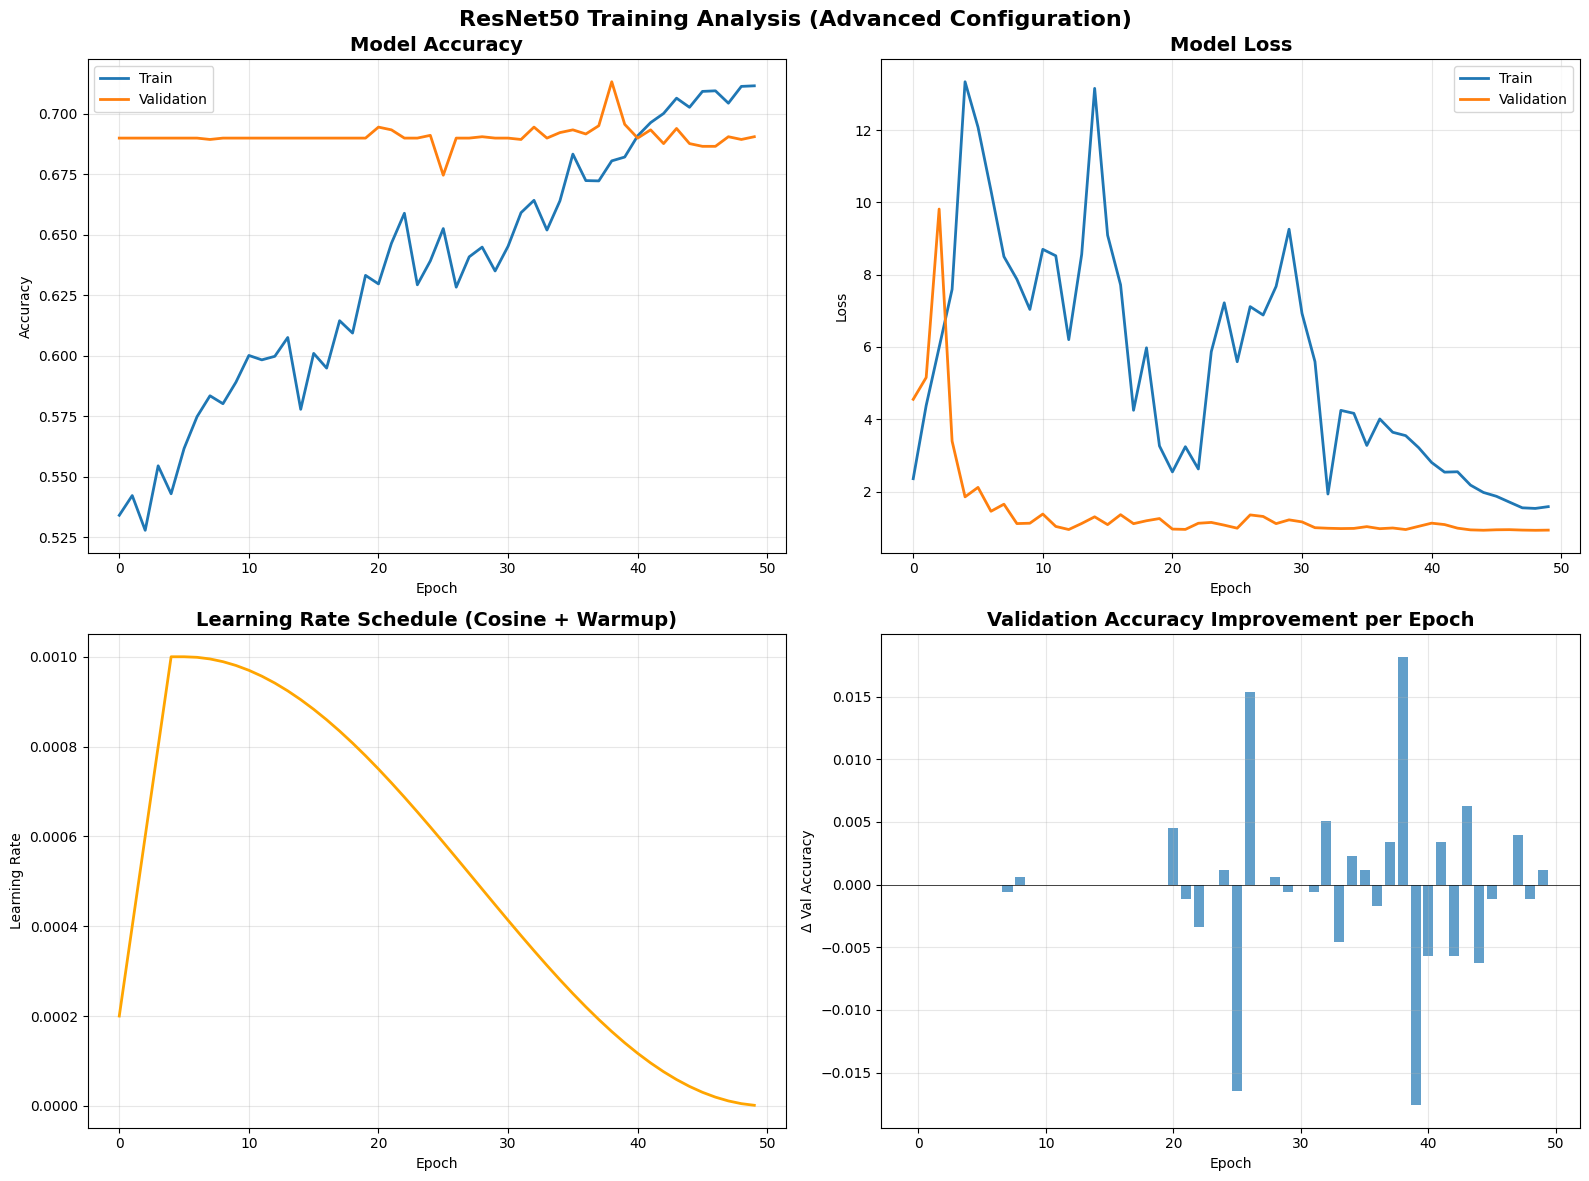

✅ Training curves saved

📊 Final Results:
   Best Val Accuracy: 0.7132
   Final Train Accuracy: 0.7116
   Final Val Accuracy: 0.6905

💾 Model saved to: ../outputs/models/resnet50_best.h5
📁 TensorBoard logs: ../outputs/logs/resnet50/
   View with: tensorboard --logdir ../outputs/logs/


In [21]:
# Save history
history_dict = history.history
with open(f'{OUTPUT_DIR}/training_history/resnet50_history.json', 'w') as f:
    json.dump({k: [float(v) for v in vals] for k, vals in history_dict.items()}, f, indent=2)

import pandas as pd
pd.DataFrame(history_dict).to_csv(
    f'{OUTPUT_DIR}/training_history/resnet50_history_detailed.csv',
    index=False
)

print(f'✅ History saved')

# Plot comprehensive training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy
axes[0, 0].plot(history_dict['accuracy'], label='Train', linewidth=2)
axes[0, 0].plot(history_dict['val_accuracy'], label='Validation', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Loss
axes[0, 1].plot(history_dict['loss'], label='Train', linewidth=2)
axes[0, 1].plot(history_dict['val_loss'], label='Validation', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Learning Rate Schedule
axes[1, 0].plot([get_lr_schedule(e, INITIAL_LR) for e in range(EPOCHS)], 
               linewidth=2, color='orange')
axes[1, 0].set_title('Learning Rate Schedule (Cosine + Warmup)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].grid(alpha=0.3)

# 4. Val Accuracy Improvement
val_acc = history_dict['val_accuracy']
improvements = [0] + [val_acc[i] - val_acc[i-1] for i in range(1, len(val_acc))]
axes[1, 1].bar(range(len(improvements)), improvements, alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].set_title('Validation Accuracy Improvement per Epoch', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Δ Val Accuracy')
axes[1, 1].grid(alpha=0.3)

plt.suptitle('ResNet50 Training Analysis (Advanced Configuration)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/training_history/resnet50_curves.png', dpi=200)
plt.show()

print(f'✅ Training curves saved')
print(f'\n📊 Final Results:')
print(f'   Best Val Accuracy: {max(history_dict["val_accuracy"]):.4f}')
print(f'   Final Train Accuracy: {history_dict["accuracy"][-1]:.4f}')
print(f'   Final Val Accuracy: {history_dict["val_accuracy"][-1]:.4f}')
print(f'\n💾 Model saved to: {OUTPUT_DIR}/models/resnet50_best.h5')
print(f'📁 TensorBoard logs: {OUTPUT_DIR}/logs/resnet50/')
print(f'   View with: tensorboard --logdir {OUTPUT_DIR}/logs/')